# 2021-11-20b A go at more structured definition of the scenarios to test

Illustration of the general SC scenario, with agent widths/lengths, the conflict space (CS), the safety margin distances $D_s$, and the entry and exit points into the safety margin area ($I_*$ and $O_*$):

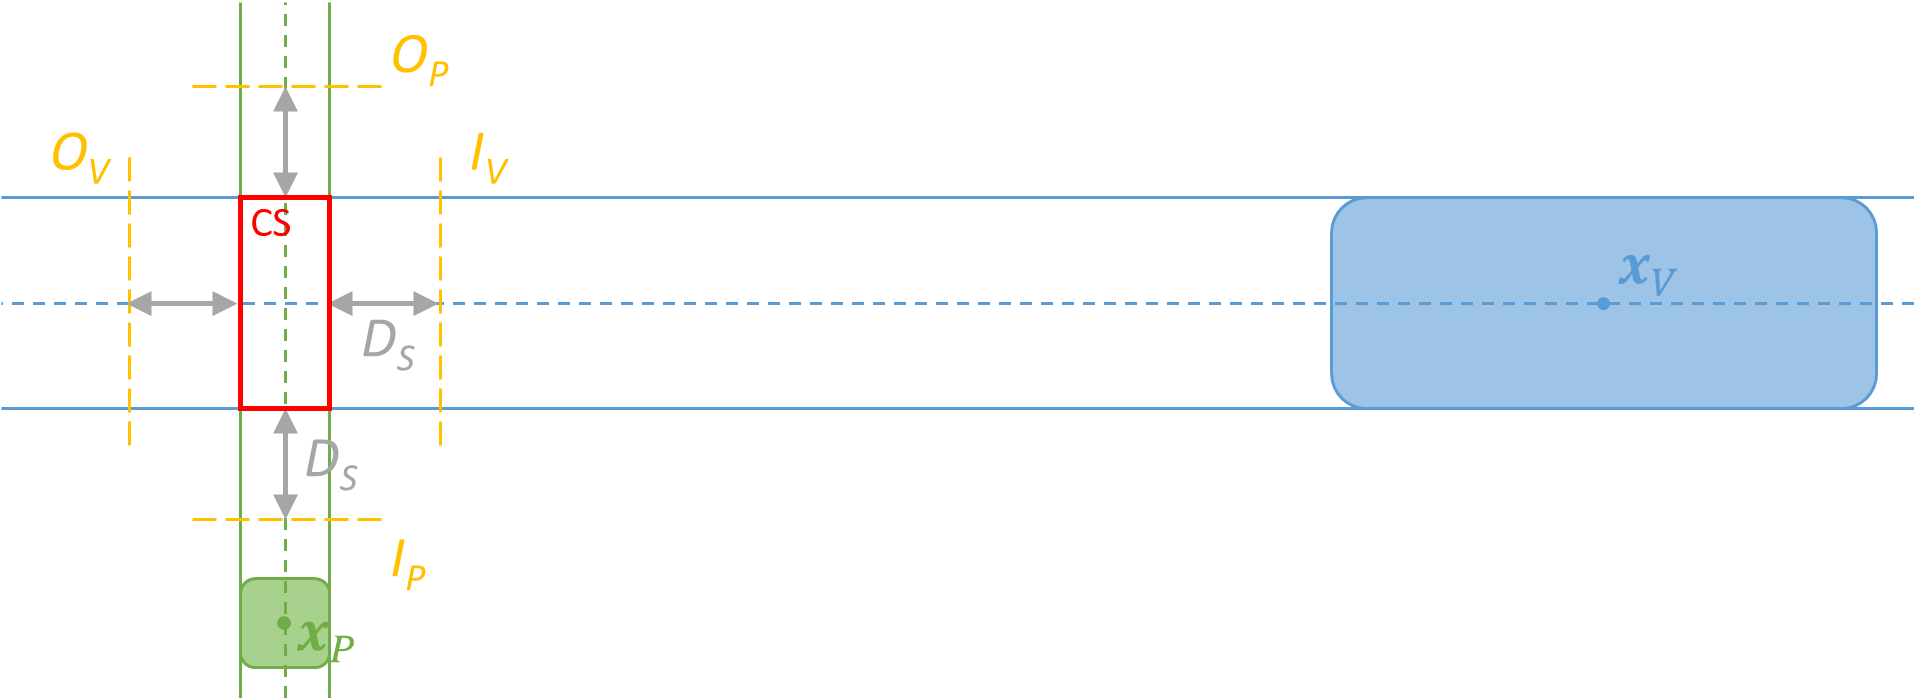

Some constants:

In [1]:
# agent dimensions
W_P = 0.8 # m
L_P = 0.8 # m
W_V = 1.8 # m
L_V = 4.2 # m
#W_P = 2 # m
#L_P = 2 # m
#W_V = 2 # m
#L_V = 2 # m

coll_dist_P = (L_P + W_V) / 2
coll_dist_V = (L_V + W_P) / 2
print(f'Collision distances are {coll_dist_P} m (\N{pedestrian}) and {coll_dist_V} m (\N{automobile}).')

# safety margins
D_s = 1 # m
T_s = 1 # s

margin_dist_P = coll_dist_P + D_s
margin_dist_V = coll_dist_V + D_s
print(f'Safety margin distances are {margin_dist_P} m (\N{pedestrian}) and {margin_dist_V} m (\N{automobile}).')

# free speeds
free_speed_P = 1.3 # m/s
free_speed_V = 50 / 3.6 # m/s

Collision distances are 1.3 m (🚶) and 2.5 m (🚗).
Safety margin distances are 2.3 m (🚶) and 3.5 m (🚗).


In all scenarios listed below, in addition to the "simulation stop criteria" listed, there should also be a max simulation time - for example 8 s as I have been using previously.

# 1. One-sided scenarios

## 1.1. `ActVehStatPed` → `VehPrioAssert`

### Scenario
P stationary throughout at $I_P$, V initially at free speed at a distance such that:
* If P crosses at its free speed, there will be a collision
* V could stop at $I_V$ without deceleration exceeding 4 m/s$^2$

In [2]:
def analyse_veh_dec_scen(dist0_P, max_dec_V):
    cross_time_P = (dist0_P + coll_dist_P) / free_speed_P
    print(f'It takes \N{pedestrian} {cross_time_P:.2f} s to cross to safety from I_P')
    max_dist_V = coll_dist_V + cross_time_P * free_speed_V
    print(f'To collide with \N{pedestrian}, max initial distance for \N{automobile} is'
          f' {max_dist_V:.1f} m (TTCS = {(max_dist_V-coll_dist_V)/free_speed_V:.2f} s).')
    min_stop_dist_V = free_speed_V ** 2 / (2 * max_dec_V)
    min_dist_V = margin_dist_V + min_stop_dist_V
    print(f'To keep stopping deceleration below {max_dec_V} m/s^2, min initial distance for'
          f' \N{automobile} is {min_dist_V:.1f} m'
          f' (TTCS = {(min_dist_V-coll_dist_V)/free_speed_V:.2f} s)')

analyse_veh_dec_scen(dist0_P = margin_dist_P, max_dec_V = 4)

It takes 🚶 2.77 s to cross to safety from I_P
To collide with 🚶, max initial distance for 🚗 is 41.0 m (TTCS = 2.77 s).
To keep stopping deceleration below 4 m/s^2, min initial distance for 🚗 is 27.6 m (TTCS = 1.81 s)


Based on the above, TTCS = 2 s as we have had it previously seems a pretty good choice.

### Phenomenon criterion
V's average speed in first half of distance to $I_V$ is greater than its free speed.

### Simulation stop criterion

V halfway from starting point to conflict space.

## 1.2. `ActVehStatPedPrio` → `VehShortStop`

### Scenario

P stationary throughout at $I_P$, V initially at free speed at a distance such that V could stop at $I_V$ without deceleration exceeding 2 m/s$^2$. (There need not be a collision course if P is crossing.)

In [3]:
analyse_veh_dec_scen(dist0_P = margin_dist_P, max_dec_V = 2)

It takes 🚶 2.77 s to cross to safety from I_P
To collide with 🚶, max initial distance for 🚗 is 41.0 m (TTCS = 2.77 s).
To keep stopping deceleration below 2 m/s^2, min initial distance for 🚗 is 51.7 m (TTCS = 3.54 s)


Based on the above, setting V's TTCS = 4 s as I have had it previously seems a pretty good choice.

### Phenomenon criterion

V's average surplus deceleration in the first half of distance to $I_V$ compared to the required deceleration to stop at $I_V$ is greater than a threshold.

### Simulation stop criterion

V at zero speed.

## 1.3. `ActPedLeading` pt 1 → `PedHesitateVehConst` 

### Scenario

V at free speed throughout, P initially at free speed, with P and V at initial distances such that:
* P's initial time to I_P is 2 s.
* If both agents continue at free speed, P will exit the safety margin space with 1 s extra safety margin above $T_s$ before V reaches the conflict space.

In [4]:
TIME_TO_I_P = 2 # s
dist0_P = margin_dist_P + TIME_TO_I_P * free_speed_P
print(f'Initial distance for \N{pedestrian} is {dist0_P:.1f} m'
      f' (TTCS = {(dist0_P-coll_dist_P)/free_speed_P:.2f} s)')
time_to_margin_dist_P = (dist0_P + margin_dist_P) / free_speed_P
EXTRA_MARGIN_TIME = 1 # s
TTCS_V = time_to_margin_dist_P + T_s + EXTRA_MARGIN_TIME
dist0_V = coll_dist_V + TTCS_V * free_speed_V
print(f'Initial distance for \N{automobile} is {dist0_V:.1f} m'
      f' (TTCS = {(dist0_V-coll_dist_V)/free_speed_V:.2f} s)')

Initial distance for 🚶 is 4.9 m (TTCS = 2.77 s)
Initial distance for 🚗 is 107.2 m (TTCS = 7.54 s)


Previously I have had the TTCSs at 3 s and 7 s, but based on the above I am thinking that I should go with 3 s and 8 s, which is the above +0.23 s and +0.46 s.

### Phenomenon criterion

P's average speed in the first half of distance to $I_P$ is lower than P's free speed.

### Simulation stop criterion

P halfway from starting point to conflict space.

## 1.4. `ActPedPrioEncounter` pt 1 → `PedHesitateVehYield`

### Scenario

Priority for P. 

P and V both initially at free speed, with V yielding with constant deceleration to stop at I_V, with P and V at initial distances such that 
* P's initial time to I_P is 2 s.
* If both agents would continue from the initial positions at their free speeds, there would be a collision.
* V's deceleration doesn't exceed 4 m/s$^2$.
* Ideally both agents should have the same TTCS - to clearly make it an "encounter" in the Varhelyi (1998) sense.

In [5]:
TIME_TO_I_P = 2 # s
dist0_P = margin_dist_P + TIME_TO_I_P * free_speed_P
print(f'Initial distance for \N{pedestrian} is {dist0_P:.1f} m'
      f' (TTCS = {(dist0_P-coll_dist_P)/free_speed_P:.2f} s)')

analyse_veh_dec_scen(dist0_P = dist0_P, max_dec_V = 4)

Initial distance for 🚶 is 4.9 m (TTCS = 2.77 s)
It takes 🚶 4.77 s to cross to safety from I_P
To collide with 🚶, max initial distance for 🚗 is 68.7 m (TTCS = 4.77 s).
To keep stopping deceleration below 4 m/s^2, min initial distance for 🚗 is 27.6 m (TTCS = 1.81 s)


Previously I used to have TTCSs for both agents at 3 s, and based on the above I think I can stick with that.

### Phenomenon criterion

P's average speed in the first half of distance to $I_P$ is lower than P's free speed.

### Simulation stop criterion

P halfway from starting point to conflict space.

## 1.5. `ActPedPrioEncounter` pt 2 → `PedCrossVehYield`

### Scenario

Priority for P. 

P initially stationary at $I_P$, V initially at free speed, yielding with constant deceleration to stop at I_V, from an initial distance such that:
* If both agents would continue from the initial positions at their free speeds, there would be a collision.
* V's deceleration doesn't exceed 4 m/s$^2$.

In [6]:
analyse_veh_dec_scen(dist0_P = margin_dist_P, max_dec_V = 4)

It takes 🚶 2.77 s to cross to safety from I_P
To collide with 🚶, max initial distance for 🚗 is 41.0 m (TTCS = 2.77 s).
To keep stopping deceleration below 4 m/s^2, min initial distance for 🚗 is 27.6 m (TTCS = 1.81 s)


Based on the above, I think I should  set the vehicle's initial TTCS to 2 s.

### Phenomenon criterion

P begins moving while V's speed is still above a threshold.

### Simulation stop criterion

P begins moving.

# 2. Two-sided scenarios

In all of these:
* The phenomenon criterion is to avoid collision.
* The simulation stop criterion is that one agent has exited the conflict space.

## 2.1. `Encounter`

Both agents initially at their free speeds, with identical TTCSs - the TTCS used in Scenario 1.4. (`PedHesitateVehYield`).

## 2.2. `EncounterPedPrio`

As the previous one, but additionally with priority for P.

## 2.3. `PedLead`

Both agents initially at their free speeds, with the TTCSs used in Scenario 1.3 (`PedHesitateVehConst`).